In [22]:
from time import time
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel

# Load Dinov2 processor and model
# Available size variants: "facebook/dinov2-small", "facebook/dinov2-base", "facebook/dinov2-large", "facebook/dinov2-giant"
# Change the model_name below to use a different size variant
model_name = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval().to(torch.device('cuda'))

# Load your images
image1 = Image.open("datasets/TartanAir/AbandonedFactory/P001/image_left/000000_left.png").convert("RGB")
image2 = Image.open("datasets/TartanAir/AbandonedFactory/P001/image_left/000002_left.png").convert("RGB")

import time
start = time.time()
inputs = processor([image1], return_tensors="pt")
inputs = {k: (v.to(model.device) if isinstance(v, torch.Tensor) else v) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

# reshape patch tokens (exclude [CLS]) into a spatial feature map B x C x H x W
patch_tokens = outputs.last_hidden_state[:, 1:, :]  # (B, N_patches, C)
B, N, C = patch_tokens.shape
print(B, N, C)
H = W = int(N ** 0.5)
feature_map = patch_tokens.transpose(1, 2).reshape(B, C, H, W)

# keep for downstream use if needed
embeddings = feature_map

end = time.time()
print(f"Time taken: {end - start:.5f} seconds")
print(feature_map.shape)

1 256 384
Time taken: 0.00459 seconds
torch.Size([1, 384, 16, 16])


In [6]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on COCO instance segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-instance")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-instance")

path = "datasets/TartanAir/AbandonedFactory/P001/image_left/000000_left.png"
image = Image.open(path).convert("RGB")
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)


class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits


result = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_instance_map = result["segmentation"]

In [8]:
predicted_instance_map

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

/tmp/ipykernel_346850/3536730182.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 20)


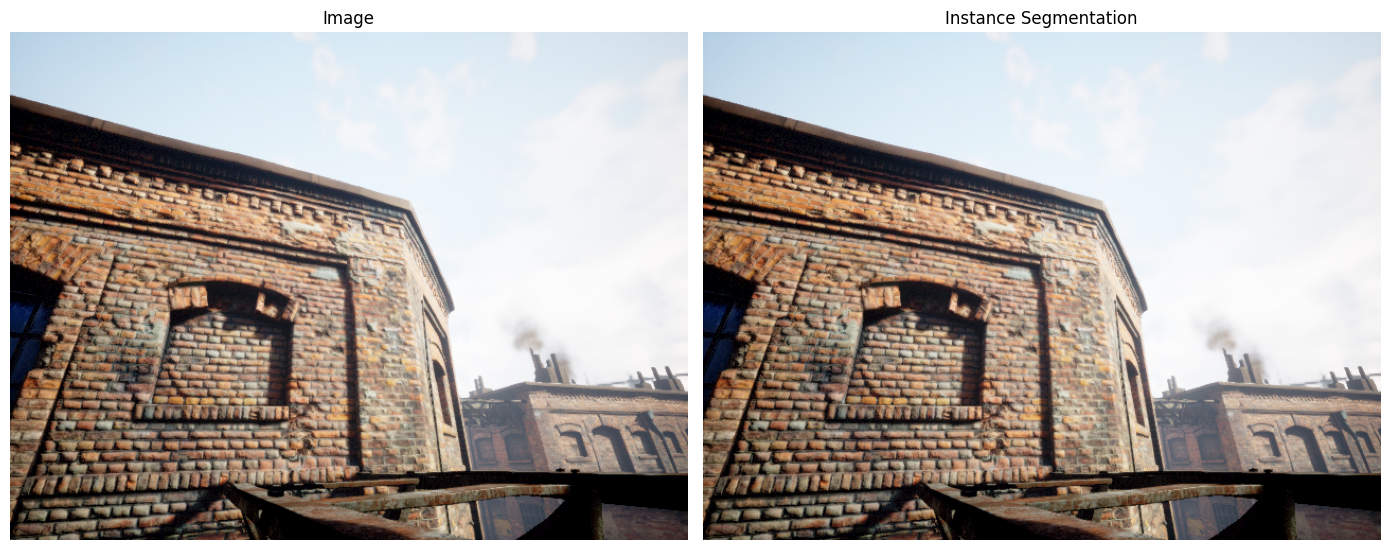

In [7]:
import numpy as np
from matplotlib.patches import Patch

import matplotlib.pyplot as plt

# Get segmentation map and segments info
seg = result["segmentation"]
seg_np = seg.detach().cpu().numpy() if hasattr(seg, "detach") else np.array(seg)
segments_info = result["segments_info"]

# Prepare colors for instances
cmap = plt.cm.get_cmap("tab20", 20)
instance_ids = [s["id"] for s in segments_info]
id_to_color = {inst_id: cmap(i % 20) for i, inst_id in enumerate(instance_ids)}

# Build RGBA overlay
overlay = np.zeros((*seg_np.shape, 4), dtype=np.float32)
for s in segments_info:
    inst_id = s["id"]
    color = id_to_color[inst_id]
    mask = seg_np == inst_id
    overlay[mask, :3] = color[:3]
    overlay[mask, 3] = 0.45  # alpha

# Legend handles
handles = []
for i, s in enumerate(segments_info):
    label = model.config.id2label.get(s["label_id"], str(s["label_id"]))
    score = s.get("score", None)
    lbl = f"{label} (id={s['id']}" + (f", {score:.2f})" if score is not None else ")")
    handles.append(Patch(facecolor=id_to_color[s["id"]], edgecolor='none', label=lbl))

# Plot image and overlay
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(image)
axes[1].imshow(overlay)
axes[1].set_title("Instance Segmentation")
axes[1].axis("off")
if handles:
    axes[1].legend(handles=handles, loc="upper right", bbox_to_anchor=(1.35, 1), fontsize="small", title="Instances")

plt.tight_layout()
plt.show()